<a href="https://colab.research.google.com/github/tewei0328/trade-backtest/blob/main/0-viz/viz6_data1_finmind_6%E6%9C%88_stock_option_future_0301_0519.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## [Day 14] 回測分析
### 從零開始的套牢生活 - AI股票預測系統 系列 第 14 篇
https://ithelp.ithome.com.tw/m/articles/10267871?fbclid=IwAR0GdoJVPIJ6VfcSdAfJzWAgHoaYahPsyBVIAY9NzjhNIfmmWHfsKYJC7Os

# 引入函式庫

In [1]:
# ! pip install backtesting
import datetime
import warnings

import pandas as pd
import requests
#from backtesting import Backtest, Strategy
#from backtesting.lib import crossover
#from backtesting.test import SMA
#from pandas.core.common import SettingWithCopyWarning

#warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
pd.set_option("display.max_columns", None)


# ***1.設定日期範圍***

In [2]:
start_date = datetime.datetime(2023, 3, 1, 0, 0).strftime("%Y-%m-%d")
end_date = datetime.datetime(2023, 5, 17, 0, 0).strftime("%Y-%m-%d")

# 取得資料
backtesting強制要求欄位名稱格式，
所以需要先轉換欄位名稱

https://finmindtrade.com/analysis/#/data/document

## 1-股票

In [3]:
stock_index = '0050'
url = "https://api.finmindtrade.com/api/v4/data"
parameter = {
    "dataset": "TaiwanStockPrice",
    "start_date": start_date,
    "end_date": end_date,
    "data_id": stock_index,
}

data = requests.get(url, params=parameter)
data = data.json()



In [4]:
#data

In [5]:
df1 = pd.DataFrame(data["data"])

df1.index = pd.to_datetime(df1["date"])
df1.rename(
    columns={
        "Trading_Volume": "Volume",
        "open": "Open",
        "max": "High",
        "min": "Low",
        "close": "Close",
    },
    inplace=True,
)

df1.drop(
    columns=["stock_id", "date", "Trading_money", "spread", "Trading_turnover"],
    inplace=True,
)

#df1

In [6]:
df1.head()

,Volume,Open,High,Low,Close
date,,,,,
2023-03-01,7996077,117.30,119.45,116.85,119.35
2023-03-02,3750827,119.35,119.35,118.30,119.25
2023-03-03,3341290,119.80,120.10,119.20,119.35
2023-03-06,9805282,120.15,120.90,119.90,120.50
2023-03-07,7894646,120.55,121.40,120.20,121.30


<Axes: xlabel='date'>

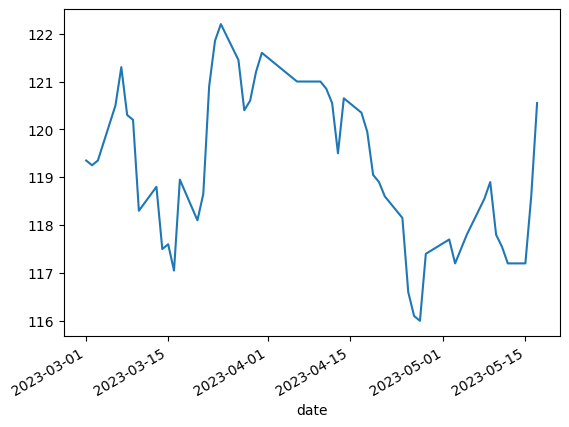

In [7]:
df1['Close'].plot()

## 2-期貨
## 期貨日成交資訊
https://finmindtrade.com/analysis/#/data/api

<Axes: xlabel='date'>

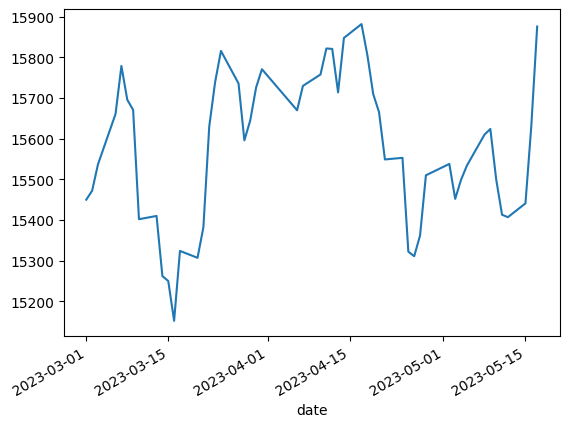

In [8]:
stock_index = "TX"
url = "https://api.finmindtrade.com/api/v4/data"
parameter = {
    "dataset": "TaiwanFuturesDaily",
    "start_date": start_date,
    "end_date": end_date,
    "data_id": stock_index,
}

data = requests.get(url, params=parameter)
data = data.json()

#data

df = pd.DataFrame(data["data"])
df.index = pd.to_datetime(df["date"])
df.head()

def get_futures(option_df, contract_period, trading_session):
    
    option_df = df.loc[(df['contract_date'] == contract_period) & \
                       (df['trading_session'] == trading_session) ]
    return option_df

# ***3.設定期貨商品***

df2=get_futures(df, '202306', 'position')

df2.head()

df2['close'].plot()

## 3-選擇權

### FinMind API 使用說明
https://finmindtrade.com/analysis/#/data/api

### 選擇權日夜盤成交資訊，包含到期月份、開高低收、漲跌幅、交易量、結算價格。
https://finmindtrade.com/analysis/#/data/document

In [9]:
stock_index = "TXO"
url = "https://api.finmindtrade.com/api/v4/data"
parameter = {
    "dataset": "TaiwanOptionDaily",
    "start_date": start_date,
    "end_date": end_date,
    "data_id": stock_index,
}

data = requests.get(url, params=parameter)
data = data.json()


In [10]:
#data

In [11]:
df = pd.DataFrame(data["data"])
df.head()

,date,option_id,contract_date,strike_price,call_put,open,max,min,close,volume,settlement_price,open_interest,trading_session
0,2023-03-01,TXO,202303W1,13800.0,call,0.0,0.0,0.0,0.0,0,0.0,0,position
1,2023-03-01,TXO,202303W1,13800.0,call,0.0,0.0,0.0,0.0,0,0.0,0,after_market
2,2023-03-01,TXO,202303W1,13800.0,put,0.2,0.2,0.2,0.2,1,0.0,83,position
3,2023-03-01,TXO,202303W1,13800.0,put,0.0,0.0,0.0,0.0,0,0.0,0,after_market
4,2023-03-01,TXO,202303W1,13900.0,call,0.0,0.0,0.0,0.0,0,0.0,1,position


In [12]:
df = pd.DataFrame(data["data"])

df.index = pd.to_datetime(df["date"])
df.rename(
    columns={
        "open": "Open",
        "max": "High",
        "min": "Low",
        "close": "Close",
    },
    inplace=True,
)

df.drop(
    #columns=["option_id", "date", "settlement_price", "open_interest", "trading_session"],
    columns=["option_id", "date", "settlement_price", "open_interest"],
    inplace=True,
)

#df

In [13]:
def get_options(option_df, contract_period, put_or_call, strike_price, trade_period):
    
    option_df = df.loc[(df['contract_date'] == contract_period) & \
                       (df['call_put'] == put_or_call) & \
                       (df['strike_price'] == strike_price) & \
                       (df['trading_session'] == trade_period) ]
    return option_df

# ***2-1.設定選擇權商品1***

In [14]:
df3=get_options(df, '202306', 'call', 16000, 'position')

In [15]:
df3.head()

,contract_date,strike_price,call_put,Open,High,Low,Close,volume,trading_session
date,,,,,,,,,
2023-03-01,202306,16000.0,call,293.0,317.0,293.0,317.0,3,position
2023-03-02,202306,16000.0,call,288.0,288.0,288.0,288.0,1,position
2023-03-03,202306,16000.0,call,327.0,327.0,327.0,327.0,1,position
2023-03-06,202306,16000.0,call,380.0,403.0,380.0,396.0,10,position
2023-03-07,202306,16000.0,call,0.0,0.0,0.0,0.0,0,position


<Axes: xlabel='date'>

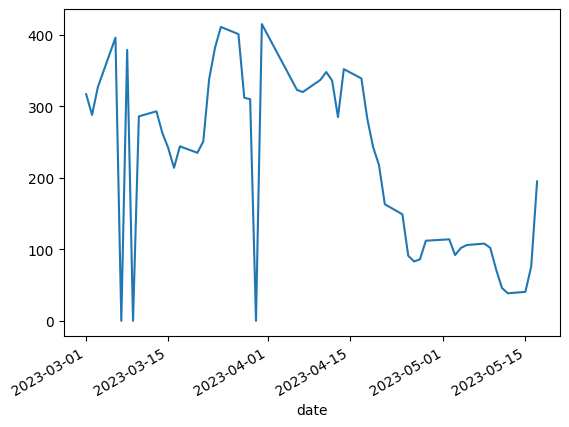

In [16]:
df3['Close'].plot()

# ***2-2.設定選擇權商品2***

In [17]:
df4=get_options(df, '202306', 'put', 15000, 'position')

In [18]:
df4.head()

,contract_date,strike_price,call_put,Open,High,Low,Close,volume,trading_session
date,,,,,,,,,
2023-03-01,202306,15000.0,put,400.0,400.0,400.0,400.0,1,position
2023-03-02,202306,15000.0,put,0.0,0.0,0.0,0.0,0,position
2023-03-03,202306,15000.0,put,360.0,360.0,360.0,360.0,1,position
2023-03-06,202306,15000.0,put,322.0,322.0,297.0,307.0,64,position
2023-03-07,202306,15000.0,put,307.0,307.0,270.0,270.0,7,position


<Axes: xlabel='date'>

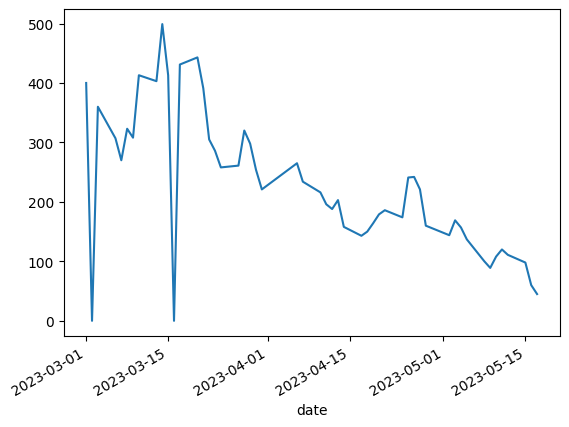

In [19]:
df4['Close'].plot()

In [20]:
df_many = pd.concat([df1.Close, df2.close, df3.Close, df4.Close], axis=1)


In [21]:
#df_many.columns=['0050','05Call-16000','05Future', '05Put-15000']
name1='0050'
name2='06Future'
name3='06Call-16000'
name4='06Put-15000'
df_many.columns=[name1,name2,name3, name4]

In [22]:
df_many.head()

,0050,06Future,06Call-16000,06Put-15000
date,,,,
2023-03-01,119.35,15450.0,317.0,400.0
2023-03-02,119.25,15472.0,288.0,0.0
2023-03-03,119.35,15537.0,327.0,360.0
2023-03-06,120.50,15661.0,396.0,307.0
2023-03-07,121.30,15779.0,0.0,270.0


<Axes: xlabel='date'>

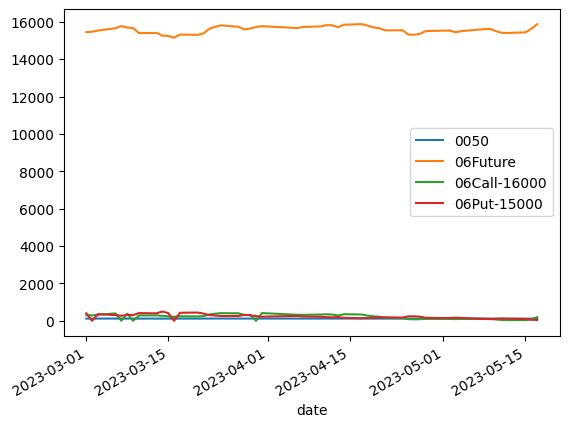

In [23]:
df_many.plot()

In [24]:
df_many1=df_many.copy()

In [25]:
#df_many['0050']=df_many['0050']/df_many.iloc[0][0]
#df_many['05Call-16000']=df_many['05Call-16000']/df_many.iloc[0][1]
#df_many['05Future']=df_many['05Future']/df_many.iloc[0][2]
#df_many['05Put-15000']=df_many['05Put-15000']/df_many.iloc[0][3]

In [26]:
#df_many1=df_many[(df_many[name2]!=0) & (df_many[name4]!=0)]

In [27]:
df_many[name1]=(df_many[name1]/df_many.iloc[0][0]-1)*1
df_many[name2]=(df_many[name2]/df_many.iloc[0][1]-1)*1
df_many[name3]=(df_many[name3]/df_many.iloc[0][2]-1)*1
df_many[name4]=(df_many[name4]/df_many.iloc[0][3]-1)*1

In [28]:
df_many.head()

,0050,06Future,06Call-16000,06Put-15000
date,,,,
2023-03-01,0.000000,0.000000,0.000000,0.0000
2023-03-02,-0.000838,0.001424,-0.091483,-1.0000
2023-03-03,0.000000,0.005631,0.031546,-0.1000
2023-03-06,0.009636,0.013657,0.249211,-0.2325
2023-03-07,0.016339,0.021294,-1.000000,-0.3250


<Axes: xlabel='date'>

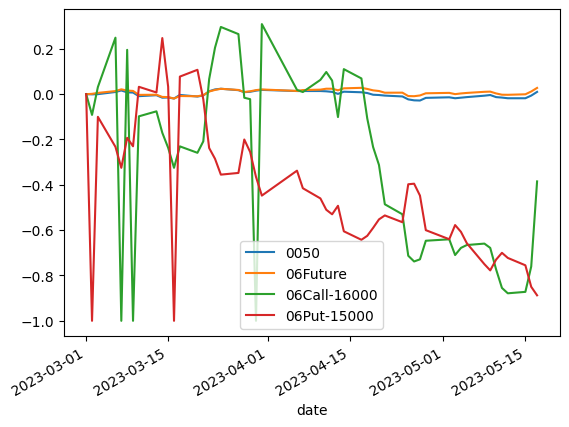

In [29]:
df_many.plot()

In [30]:
df_many.isnull().sum()

0050            0
06Future        0
06Call-16000    0
06Put-15000     0
dtype: int64

In [31]:
df_many.describe()

,0050,06Future,06Call-16000,06Put-15000
count,52.000000,52.000000,52.000000,52.000000
mean,-0.001386,0.008181,-0.304538,-0.431635
std,0.013599,0.011929,0.395643,0.293605
min,-0.028069,-0.019288,-1.000000,-1.000000
25%,-0.013196,-0.001036,-0.678233,-0.628750
50%,-0.002933,0.009903,-0.231861,-0.453750
75%,0.010159,0.017929,0.022082,-0.236250
max,0.023879,0.027961,0.309148,0.247500


注意：如果要删除多个列中的值为0的行，请使用以下语句：
df = df[(df['A'] != 0) & (df['B'] != 0)]

In [41]:
df_many=df_many[(df_many[name3]!=-1) & (df_many[name4]!=-1)]

<Axes: xlabel='date'>

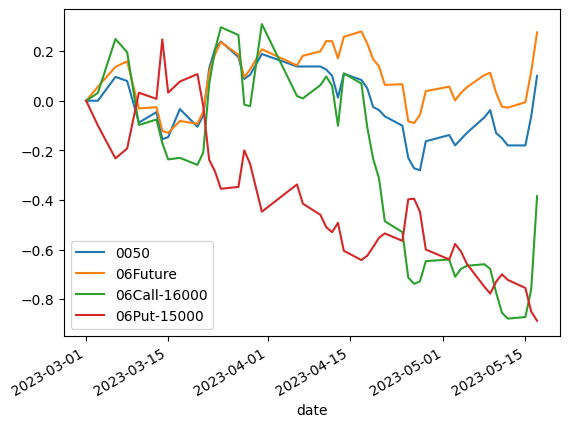

In [42]:
df_many.plot()

In [34]:
df_many=df_many1.copy()

In [35]:
df_many[name1]=(df_many[name1]/df_many.iloc[0][0]-1)*10
df_many[name2]=(df_many[name2]/df_many.iloc[0][1]-1)*10
df_many[name3]=(df_many[name3]/df_many.iloc[0][2]-1)*1
df_many[name4]=(df_many[name4]/df_many.iloc[0][3]-1)*1

In [39]:
df_many=df_many[(df_many[name3]!=-1) & (df_many[name4]!=-1)]

<Axes: xlabel='date'>

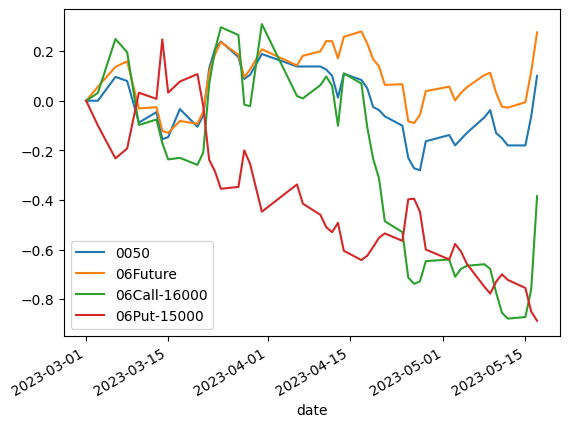

In [40]:
df_many.plot()

# 回測策略
如果快線超過慢線，表示股票進入上漲的趨勢，此時進行買空操作，分析圖表以![https://ithelp.ithome.com.tw/upload/images/20210919/20141586vhDmTPQp9Z.png](https://ithelp.ithome.com.tw/upload/images/20210919/20141586vhDmTPQp9Z.png)表示。\
如果快線跌過慢線，表示股票進入下跌的趨勢，此時進行賣空操作，分析圖表以![https://ithelp.ithome.com.tw/upload/images/20210919/20141586Y98Ntg07AE.png](https://ithelp.ithome.com.tw/upload/images/20210919/20141586Y98Ntg07AE.png)表示。\
綠色代表上一次操作的獲利情形，綠色表示獲利，綠色表示賠錢。

In [38]:
class SmaCross(Strategy):
    def init(self):
        self.fast_line = self.I(SMA, self.data.Close, 20)
        self.slow_line = self.I(SMA, self.data.Close, 50)

    def next(self):
        if crossover(self.fast_line, self.slow_line):
            print(
                f"{self.data.index[-1]} Buy: Price: {self.data.Close[-1]}, Slow: {self.slow_line[-5:]}, Fast: {self.fast_line[-5:]}"
            )
            self.buy()
        elif crossover(self.slow_line, self.fast_line):
            print(
                f"{self.data.index[-1]} Sell: Price: {self.data.Close[-1]}, Slow: {self.slow_line[-5:]}, Fast: {self.fast_line[-5:]}"
            )

            self.sell()


NameError: ignored

In [ ]:
class SmaCross1(Strategy):
# 只多不空  
    def init(self):
        self.fast_line = self.I(SMA, self.data.Close, 20)
        self.slow_line = self.I(SMA, self.data.Close, 50)

    def next(self):
        if crossover(self.fast_line, self.slow_line):
            print(
                f"{self.data.index[-1]} Buy: Price: {self.data.Close[-1]}, Slow: {self.slow_line[-5:]}, Fast: {self.fast_line[-5:]}"
            )
            #self.buy()
            # If ema1 crosses above ema2, buy the asset
            #self.position.close()
            self.buy()
        elif crossover(self.slow_line, self.fast_line):
            print(
                f"{self.data.index[-1]} Sell: Price: {self.data.Close[-1]}, Slow: {self.slow_line[-5:]}, Fast: {self.fast_line[-5:]}"
            )
            self.position.close()
            #self.sell()

# 執行策略
- cash：本金。
- commission：交易費用。
- exclusive_orders：是否禁止多頭操作(同時只能買空或賣空)。
- trade_on_close：於收盤時交易，否則預設於開盤交易。

exclusive_orders：若為True時，每次操作前自動關閉(close)上次操作。
Buy(500)、Buy(1000) -> 最後持股1000
Buy(500)、Sell(500) -> 賣空500
.
如果trade_on_close是True，市價訂單將根據當前柱的收盤價而不是下一個柱的開盤價執行。

如果hedging是True，則允許同時雙向交易。如果False，則反向訂單首先以FIFO方式關閉現有交易。

如果exclusive_orders是True，每個新訂單都會自動關閉之前的交易/頭寸，每次最多進行一次有效的交易（多頭或空頭）。

In [ ]:
test = Backtest(
    df,
    SmaCross1,
    cash=1000000,
    commission=0.004,
    exclusive_orders=True,
    trade_on_close=True,
)
result = test.run()


# 分析結果
將分析結果儲存，並利用預設瀏覽器開啟，
result為詳細的分析結果。

In [ ]:
test.plot()
print(result)

In [ ]:
#test.plot(filename=f"./backtest_result/{stock_index}.html")
#print(result)

![https://ithelp.ithome.com.tw/upload/images/20210919/20141586nTsggfN69g.png](https://ithelp.ithome.com.tw/upload/images/20210919/20141586nTsggfN69g.png)


欄位 | 說明
------------- | -------------
Start                  |   起始時間
End                    |   結束時間
Duration               |   經過天數
Exposure [%]           |   投資比率
Equity Final [$]       |   最終資產
Equity Peak [$]        |   最高資產
Return [%]             |   報酬率
Buy & Hold Return [%]  |   買入持有報酬率
Max. Drawdown [%]      |   最大交易回落
Avg. Drawdown [%]      |   平均交易回落
Max. Drawdown Duration |   最長交易回落期間
Avg. Drawdown Duration |   平均交易回落期間
Win Rate [%]           |   勝率
Best Trade [%]         |   最好交易報酬率
Worst Trade [%]        |   最差交易報酬率
Avg. Trade [%]         |   平均交易報酬率
Max. Trade Duration    |   最長交易間隔
Avg. Trade Duration    |   平均交易間隔
Expectancy [%]         |   期望值
SQN                    |   系統品質指標
Sharpe Ratio           |   夏普比率
Sortino Ratio          |   索丁諾比率
Calmar Ratio           |   卡瑪比率
_strategy              |   使用策略名稱
*From https://hackmd.io/@s02260441/SkA7IWVJv*
